In [1]:
import matplotlib.pyplot as plt

from pathlib import Path

from promg.modules.db_management import DBManagement
from tabulate import tabulate
import yaml

from promg import Configuration, DatabaseConnection, Performance, SemanticHeader, DatasetDescriptions, OcedPg, Query

import numpy as np
import pandas as pd
import nbframe

pd.set_option('display.width', 2000)
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go


In [2]:
case_study = 'bpic14'


In [3]:
conf_path = Path(case_study, 'config.yaml')
config = yaml.safe_load(open(conf_path))

print(f"These are the credentials that I expect to be set for the database.")
print(f"db_name: {config['db_name']}")
print(f"uri: {config['uri']}")
print(f"password: {config['password']}")
print("----------------------")
print(f"If you have other credentials, please change them at: {conf_path}")

These are the credentials that I expect to be set for the database.
db_name: neo4j
uri: bolt://localhost:7687
password: bpic2014
----------------------
If you have other credentials, please change them at: bpic14\config.yaml


In [9]:
config = Configuration.init_conf_with_config_file(conf_path)
db_connection = DatabaseConnection.set_up_connection(config=config)

In [10]:
# Import the original modeled data
%run ./0_analysis_and_model.ipynb

These are the credentials that I expect to be set for the database.
db_name: neo4j
uri: bolt://localhost:7687
password: bpic2014
----------------------
If you have other credentials, please change them at: bpic14\config.yaml
1it [00:12, 12.44s/it, clear_db: took 12.49 seconds]

C:\Users\s156229\PycharmProjects\EKG_BPIC2014_Notebook\.venv\Lib\site-packages\promg\utilities\performance_handling.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf.perf = pd.concat([perf.perf, pd.DataFrame.from_records([


100%|██████████| 11/11 [01:17<00:00,  6.99s/it, _filter_nodes for BPIC14Interaction: took 0.0 seconds]                     In total, there are 690626 nodes and 690622 relations.
In total (excluding record layer), there are 0 nodes and 0 relations.
Nodes
----------  ------
['Log']          4
['Record']  690622
----------  ------
Relations
--------  ------
CONTAINS  690622
--------  ------

=== INDEXES ===
Index for :Incident(sysId)
Index for :Interaction(sysId)
Index for :Change(sysId)
Index for :KnowledgeDocument(sysId)
Index for :Resource(sysId)

=== Building OBJECT NODES ===
→ Incident nodes created.
→ Interaction nodes created.
→ Change nodes created.
→ KnowledgeDocument nodes created.

=== Building RESOURCE NODES ===
→ Resource nodes created.

=== INDEXES for COMPLEX OBJECTS ===
Index for :ConfigurationItem(sysId)
Index for :ServiceComponent(sysId)
Index for :CI_SC(sysId)

=== BUILDING COMPLEX OBJECTS ===
→ ConfigurationItem nodes created.
→ ServiceComponent nodes created.
→ CI_SC 

Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. CALL subquery without a variable scope clause is deprecated. Use CALL (label) { ... }', position=<SummaryInputPosition line=3, column=13, offset=54>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 54, 'line': 3, 'column': 13}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n            CALL db.labels() YIELD label\n            CALL {\n                WITH label\n                CALL apoc.cypher.run(\n                    'MATCH (n:`' + label + '`) RETURN count(n) AS count', {}\n                ) YIELD value\n                RETURN value.count AS count\n            }\n            RETURN label, count\n     

Event                          932164
Record                         690622
IncidentActivityEvent          466737
InteractionEvent               294008
Interaction                    147004
IncidentEvent                  138038
Incident                       47057
ChangeEvent                    33381
Change                         18000
CI_SC                          15356
ConfigurationItem              15134
KnowledgeDocument              2373
ServiceComponent               340
Resource                       242
Log                            4
Entity                         0
Activity                       0
RecordType                     0

--- Relationship counts ---


Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. CALL subquery without a variable scope clause is deprecated. Use CALL (type) { ... }', position=<SummaryInputPosition line=3, column=13, offset=84>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 84, 'line': 3, 'column': 13}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n            CALL db.relationshipTypes() YIELD relationshipType AS type\n            CALL {\n                WITH type\n                CALL apoc.cypher.run(\n                    'MATCH ()-[r:`' + type + '`]->() RETURN count(r) AS count', {}\n                ) YIELD value\n                RETURN value.count AS count\n            }\n    

CORR                           3771566
EXTRACTED_FROM                 2993334
DF                             2071228
CONTAINS                       690622
EXECUTED_BY                    466737
AFFECTED_CI_SC                 223734
USED_KM                        193610
RELATED                        114378
RELATED_ACTIVITY               98283
RELATED_INCIDENT               51881
CAUSED_BY_CI_SC                45508
RELATED_CI                     15355
RELATED_SC                     15328
RELATED_CHANGE                 505

--- Totals ---
Total nodes: 1868296
Total relationships: 10752069


In [241]:
def get_count(_activity):
    print(f"Number of (:IncidentEvents {{activity: {_activity}}}) Nodes")
    # check number of events before OPENED
    number_events_query_str = '''
        MATCH (e1:IncidentEvent {activity: $activity})
        RETURN count(e1) as cnt'''
    number_events_query = Query(query_str=number_events_query_str,
                                parameters={'activity': _activity})

    df = pd.DataFrame(db_connection.exec_query(number_events_query))
    print(df)

In [242]:
def get_all_before_events(_activity):
    print(f"Number of (e:Event) - [:DF] -> (:IncidentEvents {{activity: {_activity}}})  (both for same Incident)")

    print(
        f"and some statistics on transition time of DF in minutes")
    # check number of events before OPENED
    number_before_event_query = '''
        MATCH (e1) - [df:DF] -> (e2:IncidentEvent {activity: $activity})
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WITH e1, df, e2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
        RETURN df.objectType as objectType, labels(e1)[0] as _label,
        min(diff_minutes) as min, round(avg(diff_minutes),2) as avg, max(diff_minutes) as max, stDev(diff_minutes) as stDev, count(df) as cnt
            ORDER by objectType DESC, cnt DESC'''
    before_query = Query(query_str=number_before_event_query,
                         parameters={'activity': _activity})

    df = pd.DataFrame(db_connection.exec_query(before_query))
    print(df)

In [243]:
def get_all_after_events(_activity):
    print(f"Number of (:IncidentEvents {{activity: {_activity}}}) - [:DF] -> (e:Event) (both for same Incident)")

    print(
        f"and some statistics on transition time of DF in minutes")
    # check number of events before OPENED
    after_query_str = '''
        MATCH (e1:IncidentEvent {activity: $activity}) - [df:DF] -> (e2)
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WITH e1, df, e2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
        RETURN df.objectType as objectType, min(diff_minutes) as min, round(avg(diff_minutes),2) as avg, max(diff_minutes) as max, stDev(diff_minutes) as stDev, count(df) as cnt
            ORDER by objectType DESC, cnt DESC
    '''

    after_query = Query(query_str=after_query_str,
                        parameters={'activity': _activity})

    df = pd.DataFrame(db_connection.exec_query(after_query))
    print(df)


In [244]:
def get_after_events(_activity):
    print(
        f"Number of (:IncidentEvents {{activity: {_activity}}}) - [:DF] -> (e:Event) (both for same Incident) per e.activity")

    print(
        f"and some statistics on transition time of DF in minutes")

    after_query_str = '''
        MATCH (e1:IncidentEvent {activity: $activity}) - [df:DF] -> (e2)
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WITH e1, df, e2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
        RETURN df.objectType as objectType, labels(e2)[0] as eventType, e2.activity as next_activity, min(diff_minutes) as min, round(avg(diff_minutes),2) as avg, max(diff_minutes) as max, stDev(diff_minutes) as stDev, count(df) as cnt
            ORDER by objectType DESC, cnt DESC
    '''

    after_query = Query(query_str=after_query_str,
                        parameters={'activity': _activity})

    df = pd.DataFrame(db_connection.exec_query(after_query))
    print(df)


In [245]:
def get_before_events(_activity):
    print(
        f"Number of (e:Event) - [:DF] -> (:IncidentEvents {{activity: {_activity}}})  (both for same Incident) per e.activity")
    print(
        f"and some statistics on transition time of DF in minutes")

    before_query_str = '''
        MATCH (e1) - [df:DF] -> (e2:IncidentEvent {activity: $activity})
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WITH e1, df, e2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
        RETURN df.objectType as objectType, labels(e1)[0] as eventType, e1.activity as previous_activity, min(diff_minutes) as min, round(avg(diff_minutes),2) as avg, max(diff_minutes) as max, stDev(diff_minutes) as stDev, count(df) as cnt
            ORDER by objectType DESC, cnt DESC
    '''

    before_query = Query(query_str=before_query_str,
                         parameters={'activity': _activity})

    df = pd.DataFrame(db_connection.exec_query(before_query))
    print(f"Activity: {_activity}")
    print(df)

In [246]:
activity = "Opened"
get_count(activity)
get_all_before_events(activity)


Number of (:IncidentEvents {activity: Opened}) Nodes
     cnt
0  46606
Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Opened})  (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType                 _label  min    avg  max      stDev  cnt
0      CI_SC  IncidentActivityEvent    1  63.93  119  44.014281   43


In general IncidentEvent 'Opened' is the first event for an incident.
There are only 43 incidents (out of 46606) that have another previous event.


In [247]:
get_before_events(activity)

Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Opened})  (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
Activity: Opened
   objectType              eventType            previous_activity  min     avg  max      stDev  cnt
0       CI_SC  IncidentActivityEvent                   Assignment    5   47.31   92  33.613947   13
1       CI_SC  IncidentActivityEvent              Operator Update    3   56.67  119  54.632103    6
2       CI_SC  IncidentActivityEvent                         Open  119  119.00  119   0.000000    6
3       CI_SC  IncidentActivityEvent                Status Change   20   56.75  116  42.342847    4
4       CI_SC  IncidentActivityEvent                       Update    1   64.75  118  50.109048    4
5       CI_SC  IncidentActivityEvent         Update from customer    4   30.50   57  37.476659    2
6       CI_SC  IncidentActivityEvent  Communication with customer   14   18.50   23   6.363961    2
7       CI_SC  Inc

In [248]:
get_all_after_events(activity)
get_after_events(activity)

Number of (:IncidentEvents {activity: Opened}) - [:DF] -> (e:Event) (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType  min      avg     max         stDev    cnt
0   Incident    0  7387.10  943356  27167.655930  46606
1      CI_SC    0    17.44  484964   2361.001338  46153
Number of (:IncidentEvents {activity: Opened}) - [:DF] -> (e:Event) (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
   objectType              eventType                next_activity   min       avg     max          stDev    cnt
0    Incident          IncidentEvent                     Resolved     0   7478.60  943356   27196.426260  44826
1    Incident          IncidentEvent                       Closed     0   5083.04  568662   26335.608419   1780
2       CI_SC  IncidentActivityEvent                         Open     0      0.00       0       0.000000  46023
3       CI_SC  IncidentActivityEvent                   Assignment     1

Almost all `(:IncidentEvent {activity:Opened})` are DFed by a `(:IncidentActivityEvent {activity:Opened})`
Furthermore, it takes 0 seconds to transition from one to the other.

More exactly, 46023/46153 = 99.72% are DFed this way.

Let's check which `(:Incidents)` are not DFed by a `(:IncidentActivityEvent {activity:Opened})`.

If they are at the beginning of the timeline, then it could be that we miss the open 'IncidentActivityEvent', even though we do have the Opened `IncidentEvent`.

In [249]:
query_str = '''
        MATCH (e1:IncidentEvent {activity: 'Opened'}) - [df:DF] -> (e2: IncidentActivityEvent)
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        RETURN date(min(e1.timestamp)) as min_timestamp_e1, date(max(e1.timestamp)) as max_timestamp_e1, e2.activity, (min(e2.timestamp)) as min_timestamp_e2, (max(e2.timestamp)) as max_timestamp_e2, count(e2) as cnt order by cnt DESC
'''

result = pd.DataFrame(db_connection.exec_query(query_str))
print(result)

   min_timestamp_e1 max_timestamp_e1                  e2.activity                     min_timestamp_e2                     max_timestamp_e2    cnt
0        2013-08-19       2014-03-31                         Open  2013-08-19T09:59:53.000000000+01:00  2014-03-31T17:24:50.000000000+01:00  46023
1        2013-01-22       2013-08-14                   Assignment  2013-01-23T07:08:48.000000000+01:00  2013-08-19T07:36:55.000000000+01:00     36
2        2013-01-15       2013-08-06              Operator Update  2013-01-15T16:03:24.000000000+01:00  2013-08-08T14:15:17.000000000+01:00     25
3        2013-01-23       2013-08-12                Status Change  2013-01-23T16:15:44.000000000+01:00  2013-08-12T11:04:16.000000000+01:00     20
4        2012-02-05       2013-08-15                 Reassignment  2013-01-07T08:17:17.000000000+01:00  2013-08-16T05:44:20.000000000+01:00     18
5        2013-04-26       2013-08-12                       Update  2013-04-29T06:44:20.000000000+01:00  2013-08-22T09:

The `(:IncidentActivityEvent {activity:Opened})` occurs from 2013-08-19 and from then onwards, it is always the first event after the `(:IncidentEvent {activity:Opened})`.

Let's check how many events we have before this date and after this date for any `(:Event)` node.

In [250]:
query_str = '''
        MATCH (e:Event)
        RETURN labels(e)[0] as _label, date(e.timestamp) < date("2013-08-19") as before, count(e) as cnt ORDER BY _label, before DESC
'''

result = pd.DataFrame(db_connection.exec_query(query_str))
table = pd.pivot_table(result, index=['_label', 'before'], aggfunc="sum")
table['%'] = (round(table.cnt / table.groupby(level=0).cnt.transform("sum") * 100, 2)).astype(str) + '%'
print(table)

                                 cnt       %
_label                before                
ChangeEvent           False    33254  99.62%
                      True       127   0.38%
IncidentActivityEvent False   461826  98.95%
                      True      4911   1.05%
IncidentEvent         False   137801  99.83%
                      True       237   0.17%
InteractionEvent      False   293561  99.85%
                      True       447   0.15%


Most events happen after `2013-08-19`.

Let's check how many objects have at least one event before this date.

In [251]:
results = []
for label in ['Incident', 'Interaction', 'Change', 'CI_SC']:
    query = '''
        MATCH (o:$label) - [:CORR] - (e:Event)
        WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
        WITH o, collect(distinct before_cutoff) as before_cutoffs
        MATCH (o) - [:CORR] - (other_e:Event)
        RETURN labels(o)[0] as _label, True in before_cutoffs as before, count(distinct o) as cnt
    '''
    query = Query(
        query_str=query,
        template_string_parameters={'label': label}
    )
    result = pd.DataFrame(db_connection.exec_query(query))
    results.append(result)

df_result = pd.concat(results)
table = pd.pivot_table(df_result, index=['_label', 'before'], aggfunc="sum")
table['%'] = (round(table.cnt / table.groupby(level=0).cnt.transform("sum") * 100, 2)).astype(str) + '%'
print(table)

                       cnt       %
_label      before                
CI_SC       False    12682  97.84%
            True       280   2.16%
Change      False    16611  99.51%
            True        82   0.49%
Incident    False    46378  99.49%
            True       238   0.51%
Interaction False   146553  99.69%
            True       451   0.31%


Let's explore an example

In [252]:
results = []
for label in ['Incident', 'Interaction', 'Change', 'CI_SC']:
    query = '''
        MATCH (o:$label) - [:CORR] - (e:Event)
        WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
        WITH o, collect(distinct before_cutoff) as before_cutoffs
        WHERE True in before_cutoffs
        RETURN labels(o)[0] as _label, o.sysId as sysId LIMIT 1
    '''
    query = Query(
        query_str=query,
        template_string_parameters={'label': label}
    )
    result = pd.DataFrame(db_connection.exec_query(query))
    results.append(result)

df_result = pd.concat(results)
print(df_result)

        _label                sysId
0     Incident            IM0000004
0  Interaction            SD0000001
0       Change            C00000006
0        CI_SC  OVR000012_WBS000256


In [253]:
for _label, sysId in zip(df_result['_label'], df_result['sysId']):
    query = '''
        MATCH (o:$label {sysId:$sysId}) - [:CORR] - (e:Event)
        RETURN labels(o)[0], o.sysId, labels(e)[0] as _label, e.activity, e.timestamp ORDER BY e.timestamp
    '''
    query = Query(
        query_str=query,
        template_string_parameters={
            'label': _label
        },
        parameters={'sysId': sysId}
    )
    result = pd.DataFrame(db_connection.exec_query(query))
    print(result)


   labels(o)[0]    o.sysId                 _label            e.activity                          e.timestamp
0      Incident  IM0000004          IncidentEvent                Opened  2012-02-05T13:32:57.000000000+01:00
1      Incident  IM0000004  IncidentActivityEvent          Reassignment  2013-01-07T08:17:17.000000000+01:00
2      Incident  IM0000004  IncidentActivityEvent       Operator Update  2013-09-25T08:27:40.000000000+01:00
3      Incident  IM0000004  IncidentActivityEvent       Operator Update  2013-11-04T12:09:37.000000000+01:00
4      Incident  IM0000004  IncidentActivityEvent            Assignment  2013-11-04T12:09:37.000000000+01:00
5      Incident  IM0000004  IncidentActivityEvent          Reassignment  2013-11-04T12:09:37.000000000+01:00
6      Incident  IM0000004  IncidentActivityEvent          Reassignment  2013-11-04T13:41:30.000000000+01:00
7      Incident  IM0000004  IncidentActivityEvent  Update from customer  2013-11-04T13:41:30.000000000+01:00
8      Incident  IM

Let's delete all objects that have events with a timestamp before the cutoff.
We also delete their events.

We only need to check for ['Incident', 'Interaction', 'Change'] objects.

CI_SC is an implicit object that only has events if one of these other objects has events.

In [257]:
results = []
for label in ['Incident', 'Interaction', 'Change']:
    count_query = '''
        MATCH (o:$label) - [:CORR] - (e:Event)
        WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
        WITH o, collect(distinct before_cutoff) as before_cutoffs
        WHERE True in before_cutoffs
        MATCH (o:$label) - [:CORR] - (all_e:Event)
        RETURN labels(o)[0] as _label, count(distinct o) as object_deleted, count(distinct all_e) as events_deleted
    '''
    query = Query(
        query_str=count_query,
        template_string_parameters={'label': label}
    )
    result = pd.DataFrame(db_connection.exec_query(query))
    results.append(result)

    delete_query_str = '''
        MATCH (o:$label) - [:CORR] - (e:Event)
        WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
        WITH o, collect(distinct before_cutoff) as before_cutoffs
        WHERE True in before_cutoffs
        MATCH (o:$label) - [:CORR] - (all_e:Event)

        DETACH DELETE o
        DETACH DELETE all_e
    '''

    delete_query = Query(
        query_str=delete_query_str,
        template_string_parameters={'label': label}
    )
    db_connection.exec_query(delete_query)

df_result = pd.concat(results)
df_result

,_label,object_deleted,events_deleted
0,Incident,238,8691
0,Interaction,451,902
0,Change,82,164


In [258]:
results = []
for label in ['Incident', 'Interaction', 'Change']:
    query = '''
        MATCH (o:$label) - [:CORR] - (e:Event)
        RETURN labels(o)[0] as _label, count(distinct o) as objects_kept, count(distinct e) as events_kept
    '''
    query = Query(
        query_str=query,
        template_string_parameters={'label': label}
    )
    result = pd.DataFrame(db_connection.exec_query(query))
    results.append(result)

df_result_kept = pd.concat(results)
print(df_result_kept)

        _label  objects_kept  events_kept
0     Incident         46378       596084
0  Interaction        146553       293106
0       Change         16611        33217


In [259]:
df_both = df_result.set_index('_label').join(df_result_kept.set_index('_label'))
df_both['total_objects'] = df_both['objects_kept'] + df_both['object_deleted']
df_both['total_events'] = df_both['events_kept'] + df_both['events_deleted']
df_both['% events deleted'] = round(df_both['events_deleted'] / df_both['total_events'] * 100, 2)
df_both['% objects deleted'] = round(df_both['object_deleted'] / df_both['total_objects'] * 100, 2)
df_both = df_both[
    ['object_deleted', 'objects_kept', 'total_objects', '% objects deleted', 'events_deleted', 'events_kept',
     'total_events', '% events deleted']]
print(df_both)

             object_deleted  objects_kept  total_objects  % objects deleted  events_deleted  events_kept  total_events  % events deleted
_label                                                                                                                                  
Incident                238         46378          46616               0.51            8691       596084        604775              1.44
Interaction             451        146553         147004               0.31             902       293106        294008              0.31
Change                   82         16611          16693               0.49             164        33217         33381              0.49


# Back to exploring the relationship between IncidentActivityEvent and IncidentEvent

In [260]:
activity = "Opened"
get_count(activity)
get_all_before_events(activity)


Number of (:IncidentEvents {activity: Opened}) Nodes
     cnt
0  46368
Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Opened})  (both for same Incident)
and some statistics on transition time of DF in minutes
Empty DataFrame
Columns: []
Index: []


Note: The filtering also removed all events with an earlier timestamp than the `(:IncidentEvents {activity: Opened})` events

In [262]:
get_all_after_events(activity)
get_after_events(activity)

Number of (:IncidentEvents {activity: Opened}) - [:DF] -> (e:Event) (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType  min     avg     max         stDev    cnt
0   Incident    0  6052.9  279458  16147.808891  46368
1      CI_SC    0     0.0       0      0.000000  46022
Number of (:IncidentEvents {activity: Opened}) - [:DF] -> (e:Event) (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
  objectType              eventType next_activity  min      avg     max         stDev    cnt
0   Incident          IncidentEvent      Resolved    0  6161.85  279458  16359.646602  44600
1   Incident          IncidentEvent        Closed    0  3304.39  149710   8901.183389   1768
2      CI_SC  IncidentActivityEvent          Open    0     0.00       0      0.000000  46022


TODO: Figure out why there is a small different between Incident and CI_SC.
Probably, there's an intercepting Event for same CI_SC, but different Incident

In [263]:
same_incident = '''
        MATCH (e1:IncidentEvent {activity: $activity}) - [df:DF] -> (e2: IncidentActivityEvent)
        MATCH (e1) - [:CORR] -> (i1:Incident)
        MATCH (e2) - [:CORR] -> (i2:Incident)
        RETURN i1 = i2, count(df)
    '''

same_incident_query = Query(query_str=same_incident,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(same_incident_query))
print(df)

   i1 = i2  count(df)
0     True      46022
1    False        122


Okay, for 122 incidents the next event for CI_SC is for a different Incident.

In [266]:
incident_activity = '''
        MATCH (e1:IncidentEvent {activity: $activity})
        RETURN exists((e1)- [:DF] -> (:IncidentActivityEvent)), count(e1)
    '''

incident_activity_query = Query(query_str=incident_activity,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(incident_activity_query))
print(df)

   exists((e1)- [:DF] -> (:IncidentActivityEvent))  count(e1)
0                                             True      46144
1                                            False        224


For 224. there is no succeeding `IncidentActivityEvent` nodes. Let's check the timestamp

In [267]:
incident_activity = '''
        MATCH (e1:IncidentEvent {activity: $activity})
        RETURN exists((e1)- [:DF] -> (:IncidentActivityEvent)), count(e1), min(e1.timestamp) as min, max(e1.timestamp) as max
    '''

incident_activity_query = Query(query_str=incident_activity,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(incident_activity_query))
print(df)

   exists((e1)- [:DF] -> (:IncidentActivityEvent))  count(e1)                                  min                                  max
0                                             True      46144  2013-08-19T10:09:46.000000000+01:00  2014-03-31T17:24:49.000000000+01:00
1                                            False        224  2013-09-30T13:51:38.000000000+01:00  2014-03-26T09:17:59.000000000+01:00


Let's explore an example

In [270]:
incident_activity = '''
        MATCH (e1:IncidentEvent {activity: $activity})
        WHERE NOT EXISTS((e1)- [:DF] -> (:IncidentActivityEvent))
        RETURN e1.sysId
    '''

incident_activity_query = Query(query_str=incident_activity,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(incident_activity_query))
print(df)

             e1.sysId
0    IM0001139_Opened
1    IM0001348_Opened
2    IM0001542_Opened
3    IM0001907_Opened
4    IM0001957_Opened
..                ...
219  IM0039959_Opened
220  IM0040127_Opened
221  IM0040309_Opened
222  IM0045887_Opened
223  IM0046107_Opened

[224 rows x 1 columns]


Result for the IM0001139_Opened Opened Event.
The DF does not exist, because there is an intercepting event on (:IncidentEvent) level.

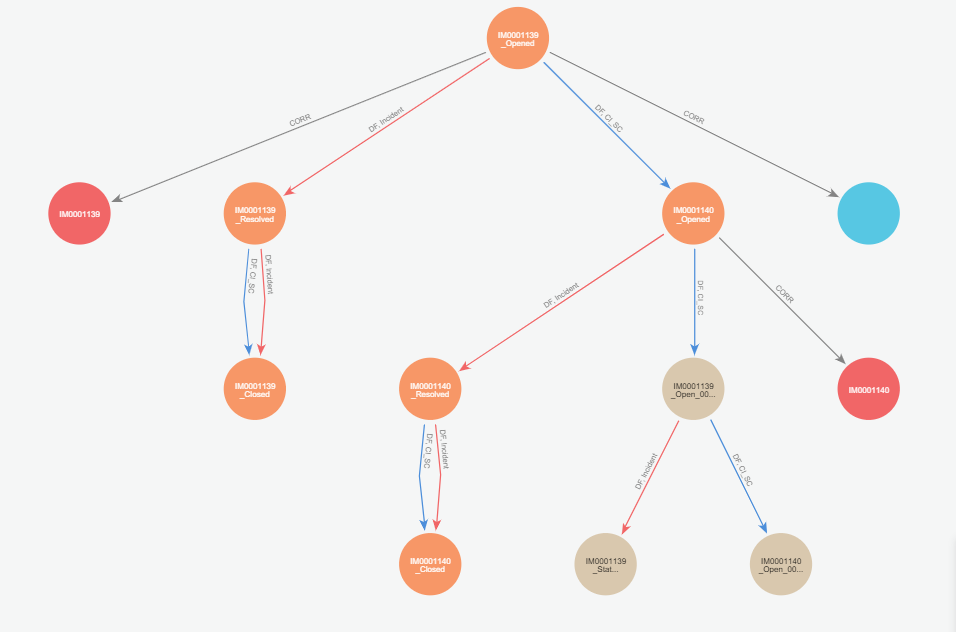

Let's remove the constraint that the next event is a `(:IncidentActivityEvent)` node.

In [277]:
incident_activity = '''
        MATCH (e1:IncidentEvent {activity: $activity}) - [df:DF] -> (e2:Event)
        MATCH (e1) - [:CORR] -> (i1:Incident)
        OPTIONAL MATCH  (e2) - [:CORR] -> (i2:Incident)
        RETURN labels(e2)[0] as _label, df.objectType as objectType, i1 = i2, count(df)
    '''

incident_activity_query = Query(query_str=incident_activity,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(incident_activity_query))
print(df)

                  _label objectType i1 = i2  count(df)
0          IncidentEvent   Incident    True      46368
1  IncidentActivityEvent      CI_SC    True      46022
2          IncidentEvent      CI_SC   False         69
3  IncidentActivityEvent      CI_SC   False        122
4       InteractionEvent      CI_SC    None        154


Okay, we still miss 46368-(46022+69+122+154) = 1 events that are not preceded by another Event.

In [275]:
incident_activity = '''
        MATCH (e1:IncidentEvent {activity: $activity})
        RETURN EXISTS((e1)- [:DF {objectType:'CI_SC'}] -> ()) as succeeding_event, count(e1)
    '''

incident_activity_query = Query(query_str=incident_activity,
                            parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(incident_activity_query))
print(df)

   succeeding_event  count(e1)
0              True      46367
1             False          1


# Let's check for Resolved

In [278]:
activity = "Resolved"
get_count(activity)
get_all_before_events(activity)


Number of (:IncidentEvents {activity: Resolved}) Nodes
     cnt
0  44600
Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Resolved})  (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType                 _label  min      avg     max         stDev    cnt
0   Incident          IncidentEvent    0  6161.85  279458  16359.646602  44600
1      CI_SC  IncidentActivityEvent    0   487.76  121235   2796.073476  14029


There are way less preceding IncidentActivityEvents for Resolved than IncidentEvents.

Is there always a resolved activity on Incident Event?

Or is there another Incident that messes the DF up?

In [279]:
query_str = '''
    MATCH (o:Incident)
    RETURN o.derivedFromInteraction, EXISTS ((o)<-[:CORR]-(:Event)) as any_event_exists, EXISTS ((o)<-[:CORR]-(:Event {activity:'Resolved'})) as resolved_exists, count(o)
'''
pd.DataFrame(db_connection.exec_query(query_str))

,o.derivedFromInteraction,any_event_exists,resolved_exists,count(o)
0,None,True,True,44668
1,None,True,False,1700
2,True,False,False,441
3,True,True,False,9
4,True,True,True,1


Resolved exists in many cases of the incidents, however not al.

Is there always any related IncidentActivityEvent eventually followed by a IncidentEvent `Resolved`?

In [280]:
number_any_before_event_on_same_incident_query = '''
        MATCH (e2:IncidentEvent {activity: 'Resolved'})
        CALL (e2) {
            OPTIONAL MATCH (e1:IncidentActivityEvent) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
            WHERE e1.timestamp < e2.timestamp
            RETURN e1 ORDER BY e1.timestamp DESC LIMIT 1
            UNION
            OPTIONAL MATCH (e1:IncidentEvent) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
            WHERE e1.timestamp < e2.timestamp
            RETURN e1 ORDER BY e1.timestamp DESC LIMIT 1
        }
        WITH e1, e2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
        RETURN labels(e1)[0] as _label, min(diff_minutes), round(avg(diff_minutes),2), max(diff_minutes), stDev(diff_minutes), count(distinct e2) as cnt ORDER BY _label DESC, cnt DESC
        '''
number_any_before_event_on_same_incident_query_query = Query(query_str=number_any_before_event_on_same_incident_query,
                                                             parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(number_any_before_event_on_same_incident_query_query))
print(df)

                  _label  min(diff_minutes)  round(avg(diff_minutes),2)  max(diff_minutes)  stDev(diff_minutes)    cnt
0          IncidentEvent                  0                     6161.85             279458         16359.646602  44600
1  IncidentActivityEvent                  0                     1806.69             258087          8184.300994  44600


Again, we have the problem of interception on the CI_SC level

In [281]:
matching_incidents = '''
    MATCH (e1) - [df:DF] -> (e2:IncidentEvent {activity: $activity})
    MATCH (e1) - [:CORR] -> (i1:Incident)
    MATCH (e2) - [:CORR] -> (i2:Incident)
    WITH e1, df, e2, i1, i2, duration.inSeconds(e1.timestamp, e2.timestamp).minutes as diff_minutes
    RETURN df.objectType as objectType, labels(e1)[0] as _label, i1 = i2, count(df) as cnt'''
matching_incidents_query = Query(query_str=matching_incidents,
                                 parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(matching_incidents_query))
print(df)

  objectType                 _label  i1 = i2    cnt
0   Incident          IncidentEvent     True  44600
1      CI_SC  IncidentActivityEvent    False  11051
2      CI_SC  IncidentActivityEvent     True  14029
3      CI_SC          IncidentEvent    False    143


In [282]:
matching_incidents = '''
    MATCH (e1) - [df:DF] -> (e2:IncidentEvent {activity: $activity})
    MATCH (e1) - [:CORR] -> (i1:Incident)
    MATCH (e2) - [:CORR] -> (i2:Incident)
    WHERE i1 <> i2
    RETURN i2.sysId as sysId LIMIT 10'''
matching_incidents_query = Query(query_str=matching_incidents,
                                 parameters={'activity': activity})

df = pd.DataFrame(db_connection.exec_query(matching_incidents_query))
df

,sysId
0,IM0000301
1,IM0000313
2,IM0000318
3,IM0000322
4,IM0000330
5,IM0000333
6,IM0000336
7,IM0000338
8,IM0000339
9,IM0000341


In [283]:
get_before_events(activity)

Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Resolved})  (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
Activity: Resolved
   objectType              eventType             previous_activity  min       avg     max         stDev    cnt
0    Incident          IncidentEvent                        Opened    0   6161.85  279458  16359.646602  44600
1       CI_SC  IncidentActivityEvent                    Assignment    0    473.54   76533   2848.068040   2972
2       CI_SC  IncidentActivityEvent              Mail to Customer    0      0.97    1047     28.550894   2374
3       CI_SC  IncidentActivityEvent               Operator Update    0    749.07   52918   2848.562264   1790
4       CI_SC  IncidentActivityEvent                 Status Change    0    703.57   53177   2537.763931   1558
5       CI_SC  IncidentActivityEvent                          Open    0    214.47  121235   3639.102468   1149
6       CI_SC  IncidentActivityEvent 

In [284]:
get_all_after_events(activity)
get_after_events(activity)

Number of (:IncidentEvents {activity: Resolved}) - [:DF] -> (e:Event) (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType  min   avg  max     stDev    cnt
0   Incident    0  0.24  134  2.615684  44600
1      CI_SC    0  0.09   89  1.172286  38920
Number of (:IncidentEvents {activity: Resolved}) - [:DF] -> (e:Event) (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
  objectType              eventType          next_activity  min   avg  max     stDev    cnt
0   Incident          IncidentEvent                 Closed    0  0.24  134  2.615684  44600
1      CI_SC          IncidentEvent                 Closed    0  0.09   89  1.176408  38646
2      CI_SC  IncidentActivityEvent               Resolved    0  0.00    0  0.000000    267
3      CI_SC  IncidentActivityEvent  Quality Indicator Set    0  0.00    0  0.000000      5
4      CI_SC  IncidentActivityEvent      Quality Indicator    0  0.00    0  0.000000 

In [285]:
activity = "Closed"
get_count(activity)
get_all_before_events(activity)


Number of (:IncidentEvents {activity: Closed}) Nodes
     cnt
0  46368
Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Closed})  (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType                 _label  min     avg     max        stDev    cnt
0   Incident          IncidentEvent    0  126.23  149710  1849.280099  46368
1      CI_SC          IncidentEvent    0    0.09      89     1.176408  38646
2      CI_SC  IncidentActivityEvent    0  371.23   14675  1337.033448   1143


In [286]:
get_before_events(activity)

Number of (e:Event) - [:DF] -> (:IncidentEvents {activity: Closed})  (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
Activity: Closed
   objectType              eventType            previous_activity   min      avg     max        stDev    cnt
0    Incident          IncidentEvent                     Resolved     0     0.24     134     2.615684  44600
1    Incident          IncidentEvent                       Opened     0  3304.39  149710  8901.183389   1768
2       CI_SC          IncidentEvent                     Resolved     0     0.09      89     1.176408  38646
3       CI_SC  IncidentActivityEvent              External update     0     0.15      30     1.834986    326
4       CI_SC  IncidentActivityEvent                     Resolved     0     9.83    2074   124.771131    295
5       CI_SC  IncidentActivityEvent                   Assignment     0   569.16   11403  1539.333224    117
6       CI_SC  IncidentActivityEvent             Vendor

In [287]:
get_all_after_events(activity)
get_after_events(activity)

Number of (:IncidentEvents {activity: Closed}) - [:DF] -> (e:Event) (both for same Incident)
and some statistics on transition time of DF in minutes
  objectType  min  avg  max  stDev    cnt
0      CI_SC    0  0.0    0    0.0  44392
Number of (:IncidentEvents {activity: Closed}) - [:DF] -> (e:Event) (both for same Incident) per e.activity
and some statistics on transition time of DF in minutes
  objectType              eventType            next_activity  min  avg  max  stDev    cnt
0      CI_SC  IncidentActivityEvent                   Closed    0  0.0    0    0.0  27207
1      CI_SC  IncidentActivityEvent             Caused By CI    0  0.0    0    0.0  14166
2      CI_SC  IncidentActivityEvent  Quality Indicator Fixed    0  0.0    0    0.0   2405
3      CI_SC  IncidentActivityEvent        Quality Indicator    0  0.0    0    0.0    613
4      CI_SC  IncidentActivityEvent    Quality Indicator Set    0  0.0    0    0.0      1


In [ ]:
%%sql


All events after closing happen immediately.

# Conclusions
1) I decided to delete all Interaction, Incident and Change objects that have timestamps before "2013-08-19T09:59:53.000000000+01:00"
  - Data is extracted based on closure time, Incidents that are opened before 31 March 2014, but not yet resolved are excluded.
    - We could trim at the end to ensure that the bulk of Opened Incidents are represented.
    - Winner of BPIC14 proposes 17 days as 95% is closed within 17 days/
2) Distinguishing Events by Label and therefore creating 2 traces for the same Incident is wrong.
- It's difficult to link the IncidentActivityEvents to the IncidentEvent
- Currently, these are only linked via CI_SC, however, this CS_SC can have multiple Incidents, so no guarantee that preceding/succeeding event is actually for the specific Incident that is resolved/closed

**Proposed Solution**
- Give all events the same label 'Event', possibly add the type (IncidentEvent/IncidentActivityEvent) as a property or concatenate with activity (to avoid duplicate activities)
    - EventSource
    - We have activities and data from four different logs, hence four different data sources. Each of these sources follow their own structure. Could be seen as a type having activities and source.
    - Aggregation on Class node --> not necessarily how you label and type your data. Combination of different features.
    - Based on XES, how Activity is modelled. Name Field, header specifies classifier for events (Concept:Name and Concept:Name+Concept:LifeCycle).
    - Under which why to classify the events.
    - Class is an object you generate. DF then is an O2O, weird type of objects.
    - If we want to explicitely support this, then we could EventClass.

- Create two entities, one for Incident and one for IncidentDetails. Not for this paper.

- We could also decide to remove the IncidentEvents. Not for this paper.
    - they often happen at the same time as a IncidentActivityEvent
    - don't add that much extra new information

However, I still think it's useful as this is like the official open/resolve/close

3) TODO: Investigate why some DF edges are missing?
Rebuild then check.